In [1]:
from importlib import reload
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import subprocess
from glob import glob
from pkg import *
from pkg.functions import convert2int, convert2str, get_params
from typing import List, Dict, Any
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from torchvision.transforms import v2

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
datasets = [1, 2, 3, 4, 5, 6, 7, 8, 9]
# datasets = [1]

myPaths = path.PathManager(datasets=datasets)
myProcessor = process.Processor(paths=myPaths, datasets=datasets)
params = myProcessor.get_parameters()
print(params)
f.get_counts(paths=myPaths, datasets=datasets)

# myDatasetManager = data.DatasetManager(paths=myPaths, datasets=datasets)

# train_loader, test_loader = f.prepare(data_manager=myDatasetManager, batch_size=10)

Water backgrounds initialized: 9
{'01': {'clen': 0.15, 'photon_energy': 6000}, '02': {'clen': 0.15, 'photon_energy': 7000}, '03': {'clen': 0.15, 'photon_energy': 8000}, '04': {'clen': 0.25, 'photon_energy': 6000}, '05': {'clen': 0.25, 'photon_energy': 7000}, '06': {'clen': 0.25, 'photon_energy': 8000}, '07': {'clen': 0.35, 'photon_energy': 6000}, '08': {'clen': 0.35, 'photon_energy': 7000}, '09': {'clen': 0.35, 'photon_energy': 8000}}
Paths refreshed for dataset ['01', '02', '03', '04', '05', '06', '07', '08', '09'].
Directory: peaks/01
	Total files: 45
	Normal images: 30
	Empty images: 15
Directory: labels/01
	Total files: 45
	Normal images: 30
	Empty images: 15
Directory: peaks_water_overlay/01
	Total files: 45
	Normal images: 30
	Empty images: 15
Directory: peaks/02
	Total files: 45
	Normal images: 30
	Empty images: 15
Directory: labels/02
	Total files: 45
	Normal images: 30
	Empty images: 15
Directory: peaks_water_overlay/02
	Total files: 45
	Normal images: 30
	Empty images: 15
Dir

In [3]:
f.check_attributes(paths=myPaths, datasets=f.convert2str(datasets), dir_type='peak')
print(myProcessor.get_parameters())

# f.retrieve_attributes(file_path=myPaths.total_paths.water_background[0])

c:\Users\ejsev\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00001.h5 conforms to expected attributes.
c:\Users\ejsev\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00001.h5:
Expected Peak: False, Actual Peak: False
c:\Users\ejsev\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00002.h5 conforms to expected attributes.
c:\Users\ejsev\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00002.h5:
Expected Peak: False, Actual Peak: False
c:\Users\ejsev\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00003.h5 conforms to expected attributes.
c:\Users\ejsev\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00003.h5:
Expected Peak: False, Actual Peak: False
c:\Users\ejsev\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00004.h5 conforms to expected attributes.
c:\Users\ejsev\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00004.h5:
Expected Peak: False, Actual Peak: False
c:\Users\ejsev\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00005.h5 conform

In [4]:
f.get_counts(paths=myPaths, datasets=datasets)
# %run process_directory.py ../../images  --percent_empty 0.5 

Paths refreshed for dataset ['01', '02', '03', '04', '05', '06', '07', '08', '09'].
Directory: peaks/01
	Total files: 45
	Normal images: 30
	Empty images: 15
Directory: labels/01
	Total files: 45
	Normal images: 30
	Empty images: 15
Directory: peaks_water_overlay/01
	Total files: 45
	Normal images: 30
	Empty images: 15
Directory: peaks/02
	Total files: 45
	Normal images: 30
	Empty images: 15
Directory: labels/02
	Total files: 45
	Normal images: 30
	Empty images: 15
Directory: peaks_water_overlay/02
	Total files: 45
	Normal images: 30
	Empty images: 15
Directory: peaks/03
	Total files: 45
	Normal images: 30
	Empty images: 15
Directory: labels/03
	Total files: 45
	Normal images: 30
	Empty images: 15
Directory: peaks_water_overlay/03
	Total files: 45
	Normal images: 30
	Empty images: 15
Directory: peaks/04
	Total files: 45
	Normal images: 30
	Empty images: 15
Directory: labels/04
	Total files: 45
	Normal images: 30
	Empty images: 15
Directory: peaks_water_overlay/04
	Total files: 45
	Norm

In [5]:
# transform = v2.Compose([
#     transform.TransformToTensor(),  # Custom transform to convert numpy array to tensor
#     v2.RandomRotation(degrees=15)         # Random rotation by +/- 15 degrees
# ])
transform = None
myDataManager = data.DatasetManager(paths=myPaths, datasets=datasets, transform=transform)
train_loader, test_loader = f.prepare(data_manager=myDataManager, batch_size=2)

Actual percentage of empty images: 33.33333333333333% across peaks, water_overlays, and labels directories.

Final dataset sizes - Peaks: 405, Labels: 405, Overlays: 405

Data prepared.
Train size: 324
Test size: 81
Batch size: 2
Number of batches in train_loader: 162 



In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
optimizer = optim.Adam
scheduler = ReduceLROnPlateau

cfg = {
    "loader": [train_loader, test_loader],
    'batch_size': train_loader.batch_size,
    'optimizer': optimizer,
    'device': device,
    'scheduler': scheduler
    }


peak_config = eval.Peak_Detection_Configuration(myPaths, datasets, device, save_path='../models/peak_model.pt')
print(f'weights for peak : {peak_config.get_loss_weights()}')
photon_config = eval.Photon_Energy_Configuration(myPaths, datasets, device, save_path='../models/photon_model.pt')
print(f'weights for photon energy : {photon_config.get_loss_weights()}')
clen_config = eval.Camera_Length_Configureation(myPaths, datasets, device, save_path='../models/clen_model.pt')
print(f'weights for camera length : {clen_config.get_loss_weights()}')

diagram_save_path = '../../docs/diagrams/'

cuda
Paths refreshed for dataset ['01', '02', '03', '04', '05', '06', '07', '08', '09'].
weights for peak : tensor([0.5000])
weights for photon energy : tensor([1., 1., 1.])
weights for camera length : tensor([1., 1., 1.])


In [7]:
# a = train_eval.TrainTestModels(cfg, peak_config)
# a.epoch_loop()
# a.plot_loss_accuracy()
# a.find_optimal_threshold()
# a.plot_roc_curve()
# a.plot_confusion_matrix()
# a.save_model()

In [8]:
# a.get_confusion_matrix()

Model testing and validating: MultiClassCNN
Looking for the feature: photon_energy
-- epoch 0
Train loss: 4.32844720394523
Train accuracy: 0.6311728358268738
Test loss: 9.712576866149902e-05
Test accuracy: 1.0
-- learning rate : [1e-06]
-- epoch 1
Train loss: 1.2938098476992712
Train accuracy: 0.6682099103927612
Test loss: 0.0003305673599243164
Test accuracy: 1.0
-- learning rate : [1e-06]
-- epoch 2
Train loss: 1.2186117617436398
Train accuracy: 0.6867284178733826
Test loss: 1.8715858459472656e-05
Test accuracy: 1.0
-- learning rate : [1e-06]
-- epoch 3
Train loss: 1.2282308196579967
Train accuracy: 0.6728395223617554
Test loss: 0.00012817978858947754
Test accuracy: 1.0
-- learning rate : [1e-06]
-- epoch 4
Train loss: 1.2341527843180997
Train accuracy: 0.6759259104728699
Test loss: 4.819035530090332e-05
Test accuracy: 1.0
-- learning rate : [1e-06]


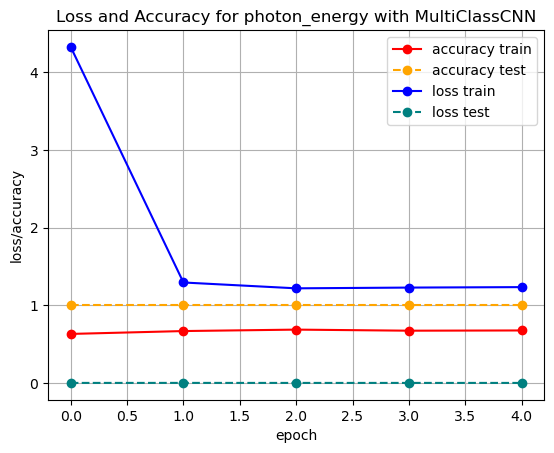

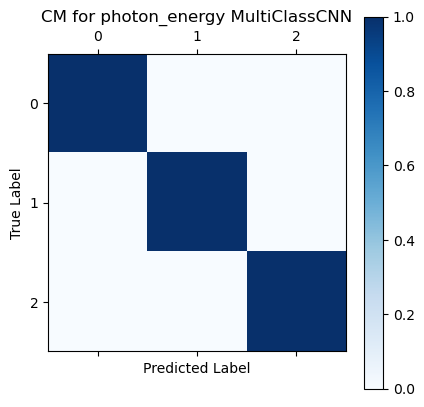

In [9]:
b = train_eval.TrainTestModels(cfg, photon_config)
b.epoch_loop()
b.plot_loss_accuracy(diagram_save_path + 'photon_energy_loss_accuracy.png')
b.plot_confusion_matrix(diagram_save_path + 'photon_energy_confusion_matrix.png')
b.save_model()

In [10]:
# photon_config.get_model_diagram('photon_energy_model.png', diagram_save_path, device)

In [11]:
b.get_confusion_matrix()

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

Model testing and validating: MultiClassCNN
Looking for the feature: clen
-- epoch 0
Train loss: 6.124407416876451
Train accuracy: 0.6682099103927612
Test loss: 0.0
Test accuracy: 1.0
-- learning rate : [1e-05]
-- epoch 1
Train loss: 14.139789473127436
Train accuracy: 0.6635802388191223
Test loss: 0.0
Test accuracy: 1.0
-- learning rate : [1e-05]
-- epoch 2
Train loss: 4.343497468365563
Train accuracy: 0.6666666865348816
Test loss: 0.0
Test accuracy: 1.0
-- learning rate : [1e-05]
-- epoch 3
Train loss: 5.260481376706818
Train accuracy: 0.6574074029922485
Test loss: 0.0
Test accuracy: 1.0
-- learning rate : [1e-05]
-- epoch 4
Train loss: 5.160579888173092
Train accuracy: 0.6898148059844971
Test loss: 0.0
Test accuracy: 1.0
-- learning rate : [1.0000000000000002e-06]


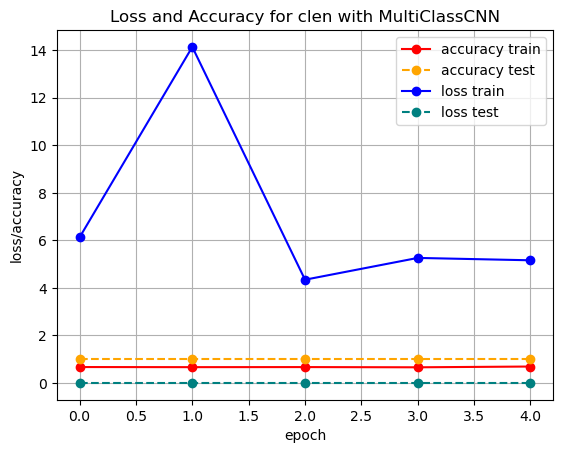

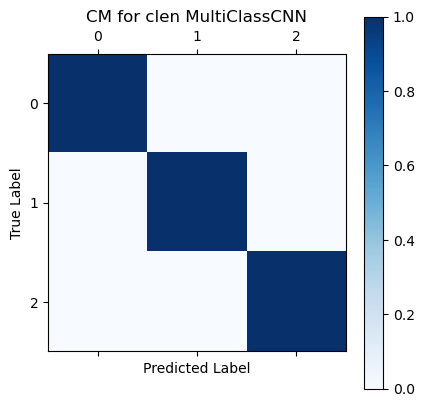

In [17]:
c = train_eval.TrainTestModels(cfg, clen_config)
c.epoch_loop()
c.plot_loss_accuracy(diagram_save_path + 'camera_length_loss_accuracy.png')
c.plot_confusion_matrix(diagram_save_path + 'camera_length_confusion_matrix.png')
c.save_model()

In [13]:
# clen_config.get_model_diagram('camera_length_model.png', diagram_save_path, device)

In [14]:
c.get_confusion_matrix()

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [15]:
# reload(pipe)
# torch.cuda.synchronize()
# torch.cuda.empty_cache()
# pipeline = pipe.ModelPipeline(peak_config, photon_config, clen_config, device)

In [16]:
# train_loader, test_loader = f.prepare(data_manager=myDataManager, batch_size=1)

# for inputs, labels, attributes in train_loader:
#     inputs = inputs[1]
#     # print(f'input size : {inputs.size()}')
#     print(f'-- attributes: {attributes}')
#     results = pipeline.run(inputs.to(device))
#     print(f'-- results: {results}')
#     break